# Avaliação Intermediária

## EDA, separação treino-teste

### Leitura dos dados

In [1]:
# Código para leitura dos dado, não esqueça de rodar!

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def read_data():
    # Load the data.
    df = pd.read_csv('student.csv').drop('Unnamed: 0', axis=1).set_index('Id')

    # Fix some weird values.
    with pd.option_context('future.no_silent_downcasting', True):
        df['Scholarship'] = df['Scholarship'].replace({
            '25%': 0.25,
            '50%': 0.50,
            '75%': 0.75,
            '100%': 1.00,
        })

    df['Attendance'] = df['Attendance'].replace('3', None)
    df['Listening_in_Class'] = df['Listening_in_Class'].replace('6', None)
    df['Notes'] = df['Notes'].replace('6', None)

    # Creating a reasonable numerical grade scale for a regression problem.
    with pd.option_context('future.no_silent_downcasting', True):
        df['Grade_numerical'] = df['Grade'].replace({
            'AA': 10.0,
            'BA': 9.0,
            'BB': 8.0,
            'CB': 7.0,
            'CC': 6.0,
            'DC': 5.0,
            'DD': 4.0,
            'Fail': 2.0,
        }).astype(float)

    # Creating a binary pass/fail grade for a classification problem.
    df['Grade_binary'] = 1
    df.loc[df['Grade'] == 'Fail', 'Grade_binary'] = 0

    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')

    # Reorder the ordinal categories.
    df['Attendance'] = df['Attendance'] \
        .cat \
        .reorder_categories(
            [
                'Never',
                'Sometimes',
                'Always',
            ],
            ordered=True,
        )
    df['Grade'] = df['Grade'] \
        .cat \
        .reorder_categories(
            [
                'Fail',
                'DD',
                'DC',
                'CC',
                'CB',
                'BB',
                'BA',
                'AA',
            ],
            ordered=True,
        )

    # Set numerical columns to float.
    df['Student_Age'] = df['Student_Age'].astype(float)
    df['Weekly_Study_Hours'] = df['Weekly_Study_Hours'].astype(float)

    # Reorder the columns of the DataFrame.
    df = df[[
        # Student demographics.
        'Student_Age',
        'Sex',

        # Student condition attributes.
        'Scholarship',
        'Transportation',

        # School attributes.
        'High_School_Type',
        'Project_work',

        # Student extracurricular habits.
        'Additional_Work',
        'Sports_activity',

        # Student study habits.
        'Weekly_Study_Hours',
        'Attendance',
        'Reading',
        'Notes',
        'Listening_in_Class',

        # Student performance.
        'Grade',
        'Grade_numerical',
        'Grade_binary',
    ]]

    return df


def sanity_check(df):
    display(df.head())
    display(df.info())

In [2]:
df = read_data()
sanity_check(df)

,Student_Age,Sex,Scholarship,Transportation,High_School_Type,Project_work,Additional_Work,Sports_activity,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Grade,Grade_numerical,Grade_binary
Id,,,,,,,,,,,,,,,,
5001,21.0,Male,0.5,Private,Other,No,Yes,No,0.0,Always,Yes,Yes,No,AA,10.0,1
5002,20.0,Male,0.5,Private,Other,Yes,Yes,No,0.0,Always,Yes,No,Yes,AA,10.0,1
5003,21.0,Male,0.5,Private,State,Yes,No,No,2.0,Never,No,No,No,AA,10.0,1
5004,18.0,Female,0.5,Bus,Private,No,Yes,No,2.0,Always,No,Yes,No,AA,10.0,1
5005,22.0,Male,0.5,Bus,Private,Yes,No,No,12.0,Always,Yes,No,Yes,AA,10.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 5001 to 5145
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Student_Age         145 non-null    float64 
 1   Sex                 145 non-null    category
 2   Scholarship         144 non-null    category
 3   Transportation      145 non-null    category
 4   High_School_Type    145 non-null    category
 5   Project_work        145 non-null    category
 6   Additional_Work     145 non-null    category
 7   Sports_activity     145 non-null    category
 8   Weekly_Study_Hours  145 non-null    float64 
 9   Attendance          144 non-null    category
 10  Reading             145 non-null    category
 11  Notes               143 non-null    category
 12  Listening_in_Class  144 non-null    category
 13  Grade               145 non-null    category
 14  Grade_numerical     145 non-null    float64 
 15  Grade_binary        145 non-null    int64

None

### Análise exploratória preliminar

In [3]:
# Código para análise exploratória preliminar dos dados, não esqueça de rodar!


def show_descriptives_single(df):
    display(df.info())
    for col in df.columns:
        # Atenção: estou convertendo as variáveis para categóricas para 
        # facilitar a visualização, pois mesmo as variáveis numéricas 
        # deste problema são, no fundo, discretas ordinais.
        display(df[col] \
            .astype('category') \
            .value_counts(dropna=False) \
            .sort_index() \
        )


def plot_single_vars(df):
    df = df.drop(['Grade_binary', 'Grade_numerical'], axis=1).copy()

    for col in df.columns:
        # Atenção: estou convertendo as variáveis para categóricas para 
        # facilitar a visualização, pois mesmo as variáveis numéricas 
        # deste problema são, no fundo, discretas ordinais.
        df[col] = df[col].astype('category')

    columns_cat = df.select_dtypes(include=['category']).columns

    width = 8

    height_per_col = 0.5
    height_per_row = []
    for col in columns_cat:
        height_per_row.append(height_per_col * len(df[col].cat.categories))
    height = sum(height_per_row)

    fig, axes = plt.subplots(
        len(columns_cat),
        1,
        figsize=(width, height),
        height_ratios=height_per_row,
    )

    for idx, col in enumerate(columns_cat):
        ax = axes[idx]

        df[col] \
            .value_counts(normalize=True) \
            .sort_index() \
            .plot \
            .barh(ax=ax, title=col, ylabel='', xlim=(0, 1))

    fig.tight_layout()

    plt.show()


def EDA_preliminary(df):
    show_descriptives_single(df)
    plot_single_vars(df)

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 5001 to 5145
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Student_Age         145 non-null    float64 
 1   Sex                 145 non-null    category
 2   Scholarship         144 non-null    category
 3   Transportation      145 non-null    category
 4   High_School_Type    145 non-null    category
 5   Project_work        145 non-null    category
 6   Additional_Work     145 non-null    category
 7   Sports_activity     145 non-null    category
 8   Weekly_Study_Hours  145 non-null    float64 
 9   Attendance          144 non-null    category
 10  Reading             145 non-null    category
 11  Notes               143 non-null    category
 12  Listening_in_Class  144 non-null    category
 13  Grade               145 non-null    category
 14  Grade_numerical     145 non-null    float64 
 15  Grade_binary        145 non-null    int64

None

Student_Age
18.0    65
19.0    17
20.0    15
21.0    21
22.0    17
23.0     1
24.0     4
25.0     3
26.0     2
Name: count, dtype: int64

Sex
Female    58
Male      87
Name: count, dtype: int64

Scholarship
 0.25     3
 0.50    76
 0.75    42
 1.00    23
NaN       1
Name: count, dtype: int64

Transportation
Bus        61
Private    84
Name: count, dtype: int64

High_School_Type
Other       17
Private     25
State      103
Name: count, dtype: int64

Project_work
No     73
Yes    72
Name: count, dtype: int64

Additional_Work
No     96
Yes    49
Name: count, dtype: int64

Sports_activity
No     87
Yes    58
Name: count, dtype: int64

Weekly_Study_Hours
0.0     93
2.0     27
8.0      4
12.0    21
Name: count, dtype: int64

Attendance
Never        21
Sometimes    25
Always       98
NaN           1
Name: count, dtype: int64

Reading
No     76
Yes    69
Name: count, dtype: int64

Notes
No     66
Yes    77
NaN     2
Name: count, dtype: int64

Listening_in_Class
No     69
Yes    75
NaN     1
Name: count, dtype: int64

Grade
Fail     8
DD      17
DC      13
CC      17
CB      10
BB      21
BA      24
AA      35
Name: count, dtype: int64

Grade_numerical
2.0      8
4.0     17
5.0     13
6.0     17
7.0     10
8.0     21
9.0     24
10.0    35
Name: count, dtype: int64

Grade_binary
0      8
1    137
Name: count, dtype: int64

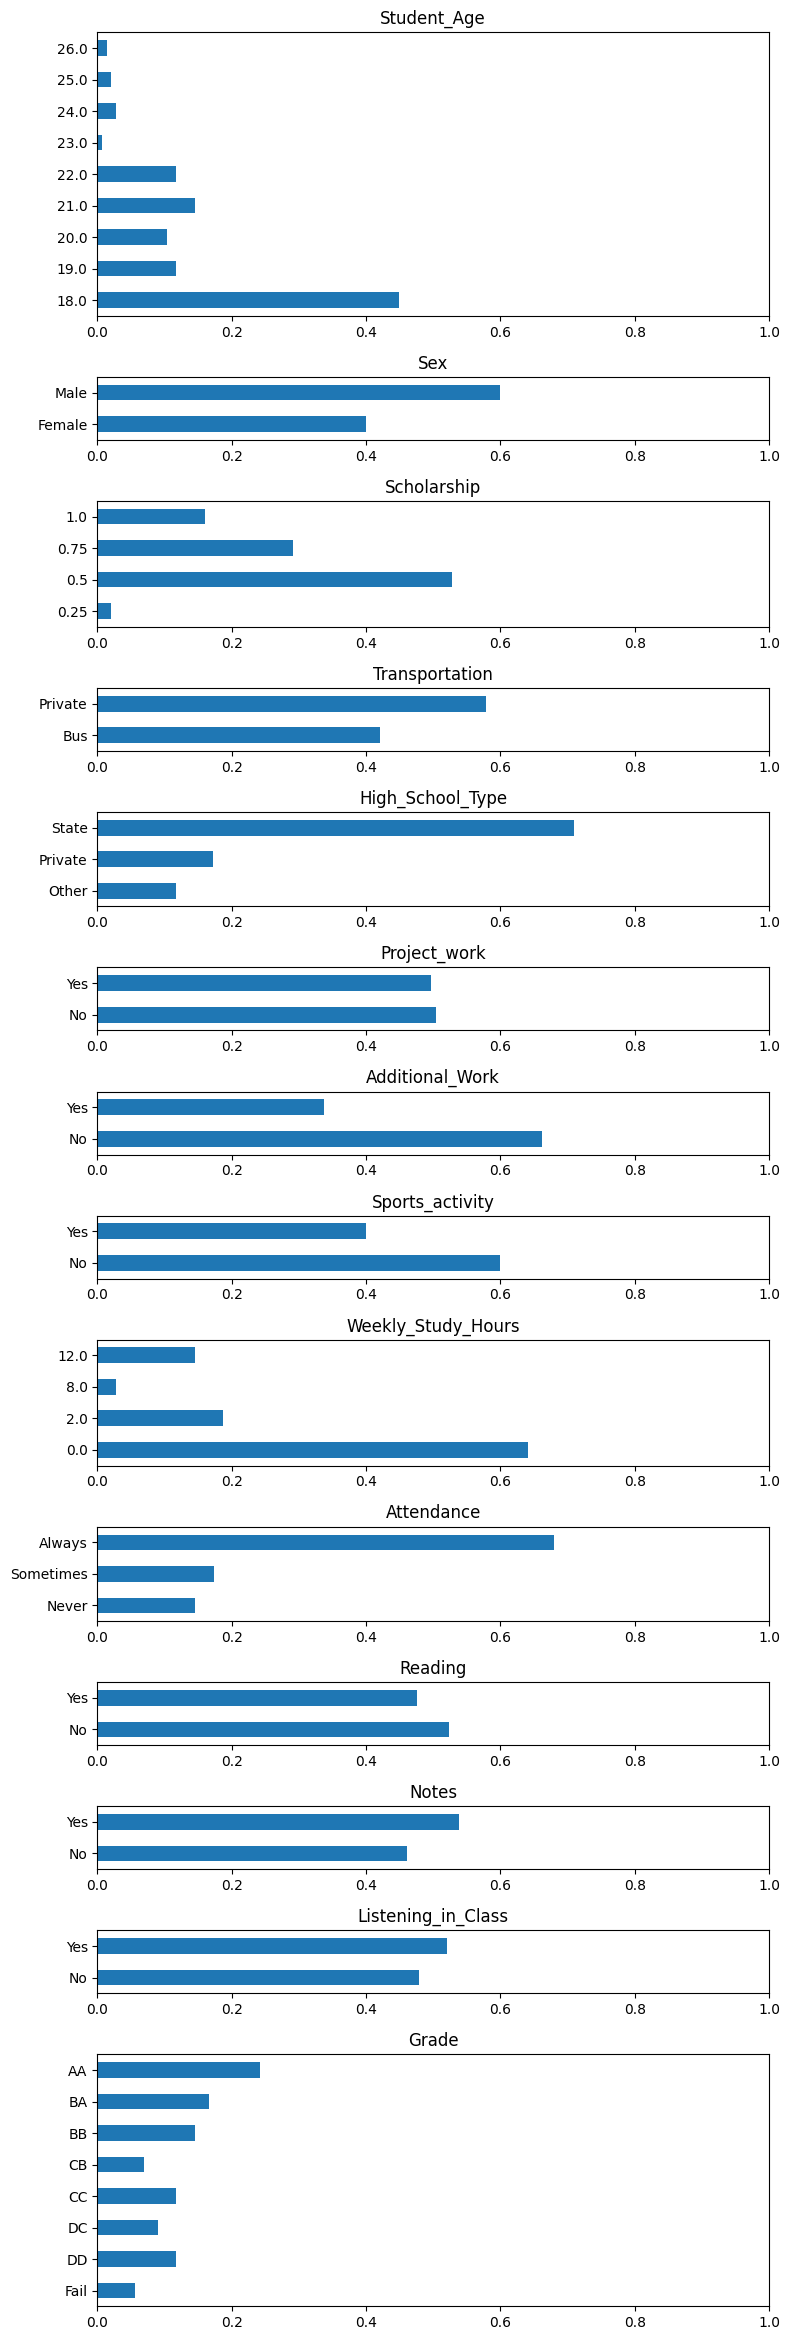

In [4]:
EDA_preliminary(df)

### Separação treino-teste

In [5]:
from sklearn.model_selection import train_test_split

SEED = 42
test_size = 0.2

train_df, test_df = train_test_split(
    df,
    test_size=test_size,
    stratify=df['Grade'],
    random_state=SEED,
)

### Análise exploratória pós-separação treino-teste

In [6]:
# Código para análise exploratória dos dados pós-separação treino-teste, não esqueça de rodar!


def plot_joint_vars(df):
    df = df.drop(['Grade_binary', 'Grade_numerical'], axis=1).copy()

    for col in df.columns:
        # Atenção: estou convertendo as variáveis para categóricas para 
        # facilitar a visualização, pois mesmo as variáveis numéricas 
        # deste problema são, no fundo, discretas ordinais.
        df[col] = df[col].astype('category')

    columns_cat = df.select_dtypes(include=['category']).columns

    nb_cat = len(columns_cat)

    height_per_row = 6
    width_per_column = 6

    height = height_per_row * nb_cat
    width = width_per_column * nb_cat

    fig, axes = plt.subplots(nb_cat, nb_cat, figsize=(width, height))

    for idx_1, col_1 in enumerate(columns_cat):
        for idx_2, col_2 in enumerate(columns_cat):
            ax = axes[idx_1, idx_2]

            if idx_1 == idx_2:
                df[col_1] \
                    .value_counts(normalize=True) \
                    .sort_index() \
                    .plot \
                    .bar(ax=ax)
            else:
                counts = pd.crosstab(df[col_1], df[col_2], normalize='index')
                counts.plot.bar(ax=ax, stacked=True, colormap='plasma')

    fig.tight_layout()

    plt.show()

In [7]:
plot_joint_vars(train_df)

## Regressão

In [8]:
X_train = train_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_train = train_df['Grade_numerical']

X_test = test_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_test = test_df['Grade_numerical']

### Construção de modelos

In [9]:
def get_column_names():
    numerical_columns = [
        'Student_Age',
        'Weekly_Study_Hours',
    ]

    categorical_columns = [
        'Student_Age',
        'Sex',
        'Scholarship',
        'Transportation',
        'High_School_Type',
        'Project_work',
        'Additional_Work',
        'Sports_activity',
        'Weekly_Study_Hours',
        'Attendance',
        'Reading',
        'Notes',
        'Listening_in_Class',
    ]

    return numerical_columns, categorical_columns

#### Definindo o modelo trivial

In [10]:
from sklearn.dummy import DummyRegressor

# Modelo trivial
def create_dummy_model():
    return DummyRegressor(strategy='mean')

#### Definindo o modelo simples

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


# Modelo simples: regressão linear
def create_simple_model():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = LinearRegression()

    simple_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return simple_model

#### Definindo o modelo complexo

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


def create_complex_model():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = HistGradientBoostingRegressor(max_depth=5, max_iter=100)

    complex_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return complex_model

In [13]:
dummmy_model = create_dummy_model()
simple_model = create_simple_model()
complex_model = create_complex_model()

models = {
    'dummy': {
        'model': dummmy_model,
    },
    'simple': {
        'model': simple_model,
    },
    'complex': {
        'model': complex_model,
    },
}

### Escolha de modelos

#### Alternativa 1: separação train_val / test_val

In [14]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=SEED,
)

In [15]:
from sklearn.metrics import root_mean_squared_error

for model_name, model_item in models.items():
    model = model_item['model']
    
    model.fit(X_train_val, y_train_val)

    y_train_pred = model.predict(X_train_val)
    rmse_train = root_mean_squared_error(y_train_val, y_train_pred)

    y_test_pred = model.predict(X_test_val)
    rmse_test = root_mean_squared_error(y_test_val, y_test_pred)

    print(f'{model_name} model:')
    print(f'  - RMSE (train): {rmse_train:.2f}')
    print(f'  - RMSE (test): {rmse_test:.2f}')
    print()


dummy model:
  - RMSE (train): 2.42
  - RMSE (test): 2.31

simple model:
  - RMSE (train): 1.88
  - RMSE (test): 2.35

complex model:
  - RMSE (train): 1.88
  - RMSE (test): 2.17



#### Alternativa 2: validação cruzada e ajuste de hiperparâmetros

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
CV = 3

In [18]:
param_grid_dummy = {
    'strategy': ['mean', 'median'],
}

param_grid_simple = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
}

param_grid_complex = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    'preprocessing__num__poly__degree': [1, 2, 3],
    'model__max_depth': [3, 5, 7],
    'model__max_iter': [50, 100, 200],
}

params = {
    'dummy': param_grid_dummy,
    'simple': param_grid_simple,
    'complex': param_grid_complex,
}

In [19]:
for model_name, model_item in models.items():
    model = model_item['model']
    param_grid = params[model_name]

    model_item['grid_search'] = GridSearchCV(
        model,
        param_grid,
        cv=CV,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
    )

In [20]:
for model_name, model_item in models.items():
    grid_search = model_item['grid_search']
    grid_search.fit(X_train, y_train)

/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_pro

In [21]:
for model_name, model_item in models.items():
    grid_search = model_item['grid_search']

    print(f'{model_name} model:')
    print(f'  - Hyperparameters search: {grid_search.param_grid}')
    print()
    print(f'  - Best hyperparameters: {grid_search.best_params_}')
    print(f'  - Best RMSE score: {-grid_search.best_score_:.2f}')
    print()

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results = df_results.sort_values(by='rank_test_score')
    display(-df_results[['mean_train_score', 'mean_test_score']].iloc[1, :].round(3))

dummy model:
  - Hyperparameters search: {'strategy': ['mean', 'median']}

  - Best hyperparameters: {'strategy': 'mean'}
  - Best RMSE score: 2.40



mean_train_score    2.498
mean_test_score     2.494
Name: 1, dtype: float64

simple model:
  - Hyperparameters search: {'preprocessing__num__imputer__strategy': ['mean', 'median']}

  - Best hyperparameters: {'preprocessing__num__imputer__strategy': 'mean'}
  - Best RMSE score: 2.78



mean_train_score    1.693
mean_test_score     2.784
Name: 1, dtype: float64

complex model:
  - Hyperparameters search: {'preprocessing__num__imputer__strategy': ['mean', 'median'], 'preprocessing__num__poly__degree': [1, 2, 3], 'model__max_depth': [3, 5, 7], 'model__max_iter': [50, 100, 200]}

  - Best hyperparameters: {'model__max_depth': 3, 'model__max_iter': 100, 'preprocessing__num__imputer__strategy': 'mean', 'preprocessing__num__poly__degree': 1}
  - Best RMSE score: 2.44



mean_train_score    1.874
mean_test_score     2.439
Name: 9, dtype: float64

### Certificação

In [22]:
best_model = models['complex']['grid_search'].best_estimator_

In [23]:
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print(f'Best model:')
print(f'  - RMSE (test): {rmse_test:.2f}')
print()

Best model:
  - RMSE (test): 2.47



## Classificação

In [26]:
X_train = train_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_train = train_df['Grade_binary']

X_test = test_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_test = test_df['Grade_binary']

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

def create_complex_model_classification():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = HistGradientBoostingClassifier(max_depth=5, max_iter=100)

    complex_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return complex_model

In [30]:
classifier = create_complex_model_classification()

In [31]:
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_test_pred)

accuracy

0.9310344827586207

/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


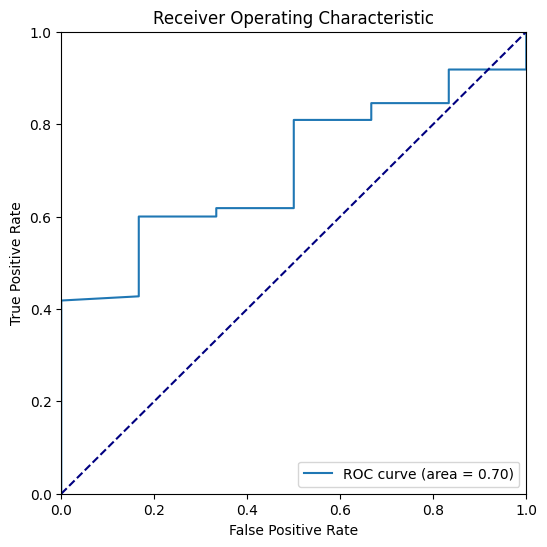

array([[ 1,  1],
       [ 1, 26]])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(classifier, X_train, y_train, cv=CV, method='predict_proba')

from sklearn.metrics import roc_auc_score, roc_curve

fpf, tpf, _ = roc_curve(y_train, y_train_pred[:, 1])
roc_auc = roc_auc_score(y_train, y_train_pred[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpf, tpf, label=f'ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

plt.show()

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)